In [ ]:
from matplotlib import pyplot as plt
from surfbreak.load_videos import decode_frame_sequence
import os

test_video = 'shirahama_1590387334_SURF-93cm.ts'
_, _, filenames =  next(os.walk('../tmp'))

if test_video not in filenames:
    !mkdir tmp
    !wget https://www.dropbox.com/s/bmr25ax60sjjmvo/shirahama_1590387334_SURF-93cm.ts?dl=1
    !mv shirahama_1590387334_SURF-93cm.ts?dl=1 tmp/shirahama_1590387334_SURF-93cm.ts
    !wget https://www.dropbox.com/s/6alfmy3l6mqv8hs/shirahama_1590387334_SURF-93cm.json?dl=1
    !mv shirahama_1590387334_SURF-93cm.json?dl=1 tmp/shirahama_1590387334_SURF-93cm.json

test_video_filepath = '../tmp/shirahama_1590387334_SURF-93cm.ts'

Decoding ../tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
300


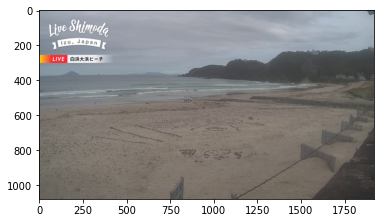

In [ ]:
frames = decode_frame_sequence(test_video_filepath, duration_s=10, start_s=100, RGB=True,
                               one_image_per_n_frames=2)
print(len(frames))
im = frames[0]
plt.imshow(im)

In [ ]:
import cv2
import numpy as np

greyscale_cube = np.dstack([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in frames])
greyscale_cube.shape

(1080, 1920, 300)

In [ ]:
im.shape

(1080, 1920, 3)

## Now we can isolate the wave fronts as they move

General approach is to do the following:
1. Calculate a dense optical flow on the scene
1. Find the dominant direction of movement of these gradients over time
1. Trim the scene to only include the area which contains this dominant flow

### The variation of this scaled cube per pixel shows where the waves are breaking (and other noise)

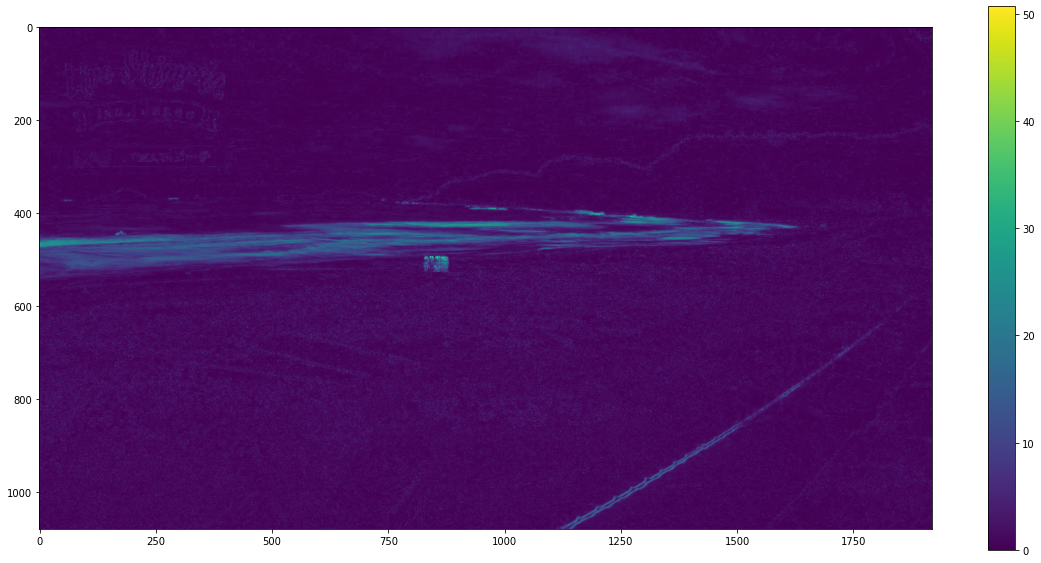

In [ ]:
plt.figure(figsize=(20,10))
im=plt.imshow(greyscale_cube.std(axis=2))
plt.colorbar(im)

#### Next, perform dense optical flow on the gradient to find the primary wave direction

TODO: some comparisons between quality of optical flow on the unnormalized image and on the gradient

In [ ]:
#export
import numpy as np
import cv2

def dense_optical_flow(image_cube, start_idx=0, n_flows=None, step_size=1):
    """xy flow:  Y is down, X is to right in image space
       hsv flow: hue/saturation encode direction, value (magnitude) is in index 2"""
    if n_flows is None:
        n_flows = (image_cube.shape[-1] // step_size) - 1
        
    prv_img = image_cube[:,:,start_idx]
    hsv = np.zeros((prv_img.shape[0], prv_img.shape[1], 3), dtype='float32')
    hsv[...,1] = 255
    flows = []
    hsv_flows = []
    for i in range(n_flows-1):
        next_img = image_cube[:,:,step_size*(i+1) + start_idx]
        flow = cv2.calcOpticalFlowFarneback(prv_img,next_img, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flows.append(flow)

        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = mag # cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
        hsv_flows.append(rgb)

        prv_img = next_img
        
    xy_flow_cube = np.stack(flows, axis=3)
    hsv_flow_cube = np.stack(hsv_flows, axis=3)
    return xy_flow_cube, hsv_flow_cube


#### Optical flow on raw greyscale  
(Works well even without the scaling)

In [ ]:
xy_cube, hsv_cube = dense_optical_flow(greyscale_cube, start_idx=1, n_flows=20, step_size=2)
print(xy_cube.shape)
print(hsv_cube.shape)

(1080, 1920, 2, 19)
(1080, 1920, 3, 19)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


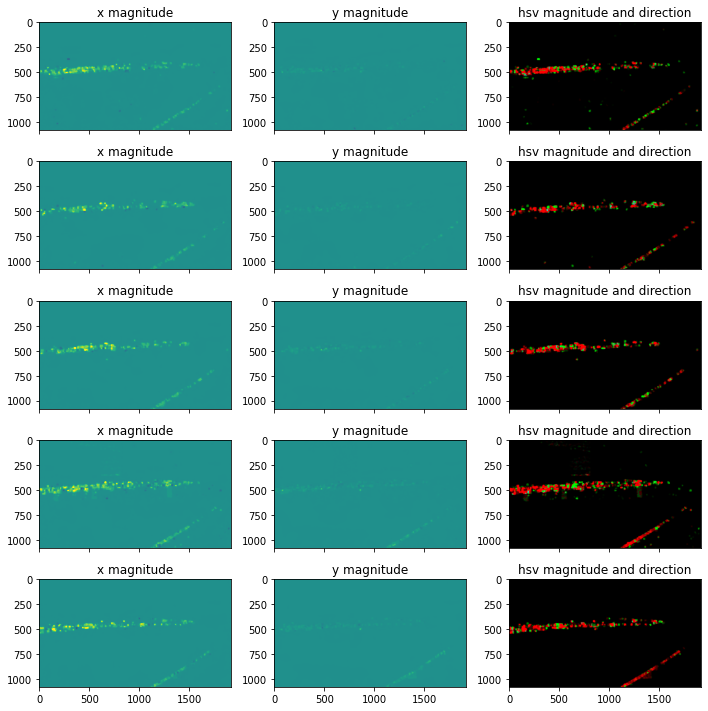

In [ ]:
if xy_cube.shape[-1] > 5:
    pltflows = xy_cube[..., :5]
else:
    pltflows = xy_cube
nrows = pltflows.shape[-1]
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(10, nrows*2), sharex='all')
for idx in range(nrows):
    axes[idx][0].imshow(pltflows[:,:,0,idx], vmin=-3, vmax=3)
    axes[idx][0].set_title('x magnitude')
    axes[idx][1].imshow(pltflows[:,:,1,idx], vmin=-3, vmax=3)
    axes[idx][1].set_title('y magnitude')
    axes[idx][2].imshow(hsv_cube[:,:,:,idx])
    axes[idx][2].set_title('hsv magnitude and direction')
plt.tight_layout()

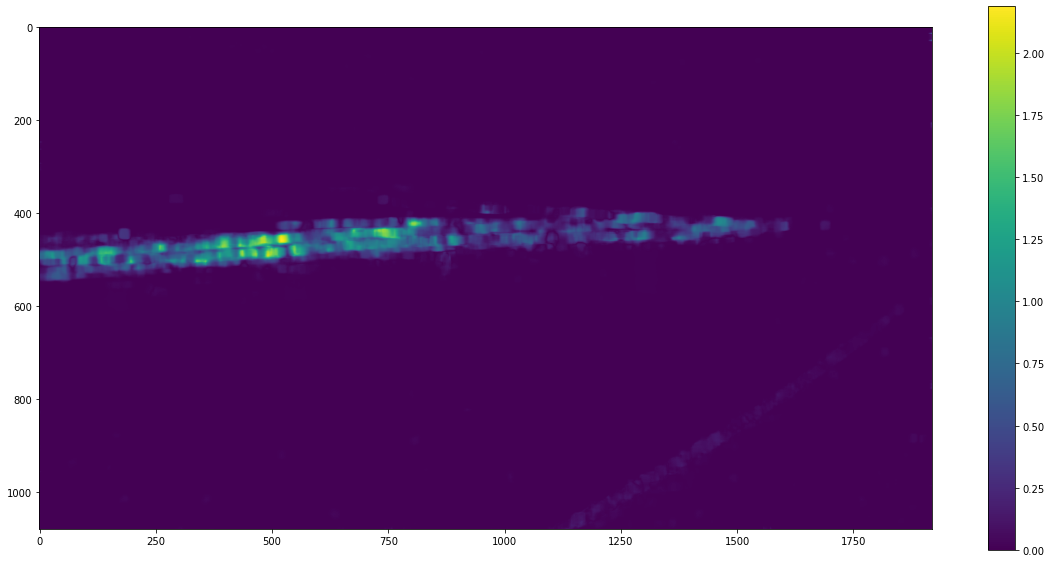

In [ ]:

mean_xflow = xy_cube[:,:,0,:].mean(axis=2)
mean_yflow = xy_cube[:,:,1,:].mean(axis=2)
mean_flow_mag = np.sqrt(mean_yflow*mean_yflow + mean_xflow*mean_xflow)
plt.figure(figsize=(20,10))
im = plt.imshow(mean_flow_mag)
plt.colorbar(im)
plt.show()

#### Zoomed-in analysis of the flow vector field

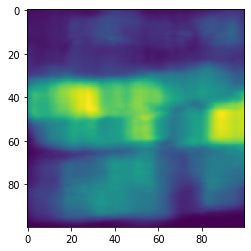

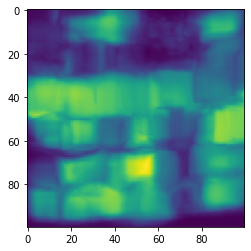

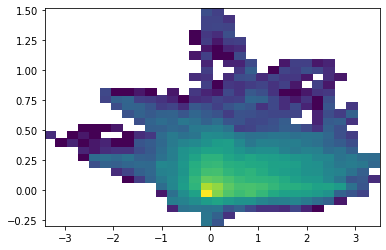

1.8257684051990506

In [ ]:
import matplotlib
zoom_xflow = xy_cube[450:550,0:100,0,:]
zoom_yflow = xy_cube[450:550,0:100,1,:]
zoom_flow_mag = np.sqrt(zoom_yflow*zoom_yflow + zoom_xflow*zoom_xflow)
plt.imshow(zoom_flow_mag.mean(axis=2))
plt.show()

top_flow_mag = np.percentile(zoom_xflow, 95, axis=2) 
im = plt.imshow(top_flow_mag)
plt.show()
nrm = matplotlib.colors.LogNorm()
plt.hist2d(zoom_xflow.flatten(), zoom_yflow.flatten(), bins=30, norm=nrm)
plt.show()
np.percentile(zoom_xflow, 95) 

### Perform fit to the heatmap generated by optical flow

In [ ]:
#export
def heatmap_fit(input_heatmap, draw_fit=False, buffer_px=0):
    """Returns (xrange, yrange) of the best fit to given heatmap"""
    
    frame = input_heatmap

    # setup initial location of window (top-left corner, plus x and y offsets)
    # X is left-to-right, Y is top-to-bottom
    x, y, w, h = frame.shape[1]//4, 0, frame.shape[1], frame.shape[0]//2 # simply hardcoded the values
    track_window = (x, y, w, h)

    # Setup the termination criteria, either 10 iteration or move by atleast 1 pt
    term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 1 )

    # Define the target heatmap
    prob_image = frame

    # apply camshift to get the new location
    ret, track_window = cv2.CamShift(prob_image, track_window, term_crit)
    
    pts = cv2.boxPoints(ret)
    pts = np.int0(pts)    
    if draw_fit:
        import matplotlib.pyplot as plt
        # Draw it on image

        img2 = cv2.polylines(frame.copy(),[pts],True, 1,2)
        plt.figure(figsize=(10,5))
        plt.imshow(img2)
        plt.show()

    max_x = min(frame.shape[1], max(p[0] for p in pts) + buffer_px)
    min_x = max(0, min(p[0] for p in pts) - buffer_px)
    max_y = min(frame.shape[0], max(p[1] for p in pts) + buffer_px)
    min_y = max(0, min(p[1] for p in pts) - buffer_px)
    
    return (min_x, max_x), (min_y, max_y)

In [ ]:
xy_cube, hsv_cube = dense_optical_flow(greyscale_cube, start_idx=1, 
                                       n_flows=50, step_size=2)
mean_xflow = xy_cube[:,:,0,:].mean(axis=2)
mean_yflow = xy_cube[:,:,1,:].mean(axis=2)
mean_flow_mag = np.sqrt(mean_yflow*mean_yflow + mean_xflow*mean_xflow)

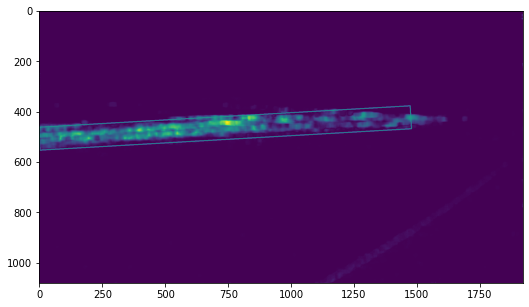

((0, 1477), (376, 552))

In [ ]:
xrange, yrange = heatmap_fit(mean_flow_mag, draw_fit=True)
xrange, yrange

## Package into a single function to crop and produce an averaged wave vector

In [ ]:
#export
def trim_image(image, xrange, yrange):
    return image[yrange[0]:yrange[1], xrange[0]:xrange[1]]

In [ ]:
#export
from surfbreak import load_videos
import matplotlib.pyplot as plt
import numpy as np
import cv2
import dask

def avg_wave_flows(video_file, start_s, duration_s=1):
    """Detects the region of the image which contains breaking waves. 
    Returns a 2-tuple (mean_flow_x, mean_flow_y):
        mean_flow_mag: a dense estimate of the average optical flow across the input image
        xrange: x range of detected waves
        yrange: y range of detected waves"""
    
    frames = load_videos.decode_frame_sequence(video_file, duration_s=duration_s, start_s=start_s, RGB=True,
                                                  one_image_per_n_frames=4)
    
    

    greyscale_cube = np.dstack(tuple(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in frames))

    xy_cube, hsv_cube = dense_optical_flow(greyscale_cube, start_idx=0, n_flows=None, step_size=1)

    return xy_cube.mean(axis=3)

def accumulate_flows(avg_flows):
    mean_flow = np.stack(avg_flows,axis=3).mean(axis=3)
    return mean_flow

def fit_mean_flows(avg_flows, draw_fit=False):
    mean_flow = accumulate_flows(avg_flows)
    mean_flow_mag = np.sqrt(mean_flow[:,:,0]*mean_flow[:,:,0] + mean_flow[:,:,1]*mean_flow[:,:,1])
    
    xrange, yrange = heatmap_fit(mean_flow_mag, draw_fit=draw_fit)
    
    return mean_flow, xrange, yrange



In [ ]:
#export
def get_sample_start_times(video_file, n_samples=10, duration_s=1):
    """Returns N equally spaced video start times in seconds"""
    video_length_s = load_videos.video_length_s(video_file)
    sample_spacing = int((video_length_s - 1) / n_samples)
    if sample_spacing - (duration_s/n_samples) < 1:
        n_samples =  (duration_s // sample_spacing) - 1
    
    start_times_s = [sample_spacing * i for i in range(n_samples)]
    return start_times_s

def detect_surfzone(video_file, n_samples=10, processes=4, draw_fit=False, scheduler='threads'):
    """Detects the region of the image which contains breaking waves, using cached graph 
        Returns a 3-tuple (mean_flow_xy, xrange, yrange):"""
    start_times = get_sample_start_times(video_file, n_samples=n_samples)
    print("Video subsample start times (seconds):", start_times)
    average_flows = [avg_wave_flows(video_file, start_s=st, duration_s=1)
                     for st in start_times]
    mean_flow, xrange, yrange = fit_mean_flows(average_flows, draw_fit=True)
    return mean_flow, xrange, yrange

Video subsample start times (seconds): [0, 399, 798]
Decoding ../data/shirahama_1592790996_SURF-129cm.ts  Duration: 20.0m (1200.03s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding ../data/shirahama_1592790996_SURF-129cm.ts  Duration: 20.0m (1200.03s)  FPS: 60.0  Emitting 1/4 of frames 
Decoding ../data/shirahama_1592790996_SURF-129cm.ts  Duration: 20.0m (1200.03s)  FPS: 60.0  Emitting 1/4 of frames 


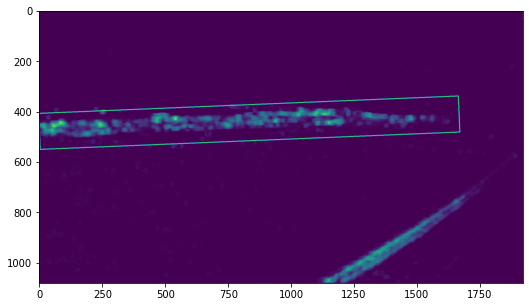

X range:  (0, 1669)    Y range:  (337, 549)


In [ ]:
import graphchain

mean_flow, xrange, yrange = detect_surfzone('../data/shirahama_1592790996_SURF-129cm.ts', n_samples=3, draw_fit=True)

print("X range: ", xrange, "   Y range: ", yrange)

Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]
Video subsample start times (seconds): [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080]
Video subsample start times (seconds): [0, 119, 238, 357, 476, 595, 714, 833, 952, 1071]


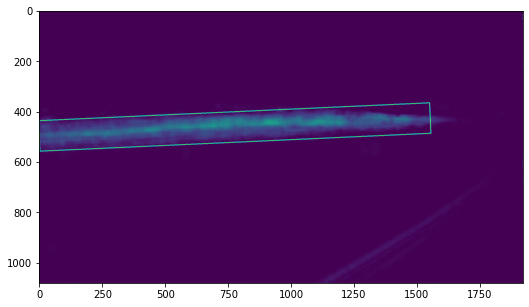

(0, 1554) (364, 556)


In [ ]:
from surfbreak.transform import run_surfzone_detection
from surfbreak.pipelines import SURFSPOT_CALIBRATION_VIDEOS
calibration_videos = SURFSPOT_CALIBRATION_VIDEOS['shirahama']
xrange,yrange = run_surfzone_detection(calibration_videos)
print(xrange,yrange)

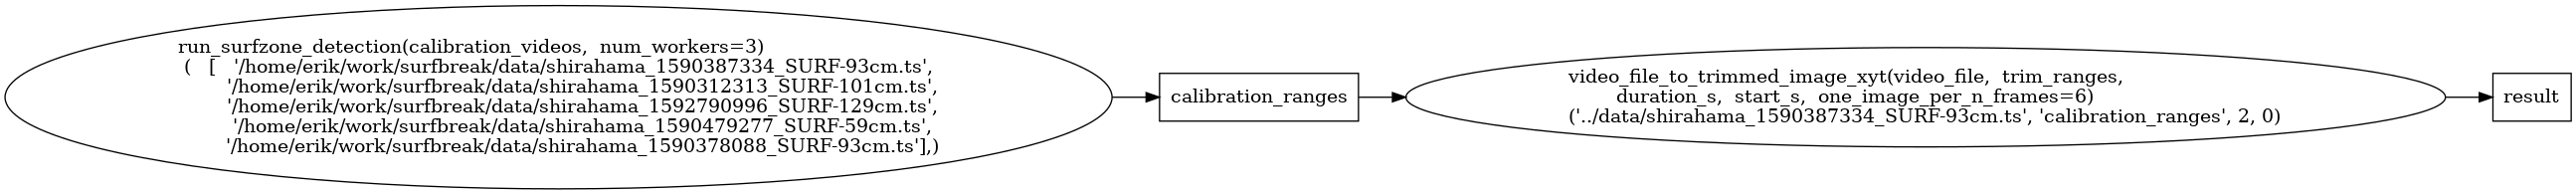

In [ ]:
from surfbreak.pipelines import video_to_waveform_tensor_simple, video_to_trimmed_array_yxt
from surfbreak.graphutils import visualize
video_filepath='../data/shirahama_1590387334_SURF-93cm.ts'

dask_graph = video_to_trimmed_array_yxt(video_filepath, duration_s=2, start_s=0)
visualize(dask_graph)

In [ ]:
import graphchain
wavefront_array = graphchain.get(dask_graph, 'result')

Decoding ../data/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/6 of frames 


In [ ]:
wavefront_array.shape

(192, 1554, 20)

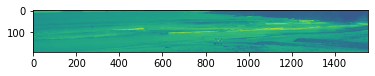

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(wavefront_array[:,:,0])